In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
df = pd.read_csv('clean_laptop_data.csv')
df.head()

,Company,TypeName,Ram,OpSys,Weight,Price,TouchScreen,IPS,PPI,CpuBrand,CpuSpeed,HDD,SSD,GpuBrand
0,Apple,Ultrabook,8,MacOS,1.37,71378.6832,0,1,226.98,Intel Core i5,2.3,0,128,Intel
1,Apple,Ultrabook,8,MacOS,1.34,47895.5232,0,0,127.68,Intel Core i5,1.8,0,0,Intel
2,HP,Notebook,8,Others/No OS/Linux,1.86,30636.0000,0,0,141.21,Intel Core i5,2.5,0,256,Intel
3,Apple,Ultrabook,16,MacOS,1.83,135195.3360,0,1,220.53,Intel Core i7,2.7,0,512,AMD
4,Apple,Ultrabook,8,MacOS,1.37,96095.8080,0,1,226.98,Intel Core i5,3.1,0,256,Intel


(array([473., 448., 231.,  98.,  37.,   8.,   3.,   2.,   1.,   1.]),
 array([  9270.72,  40839.12,  72407.52, 103975.92, 135544.32, 167112.72,
        198681.12, 230249.52, 261817.92, 293386.32, 324954.72]),
 <BarContainer object of 10 artists>)

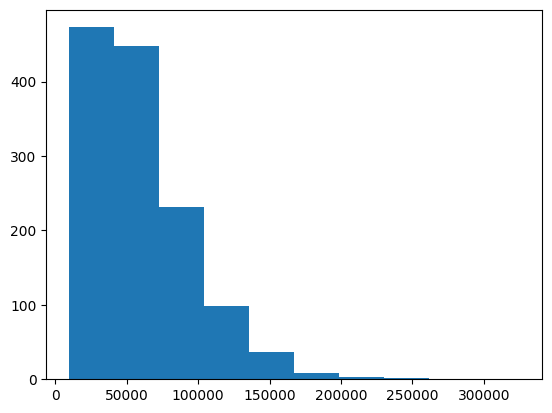

In [21]:
plt.hist(df['Price'])

In [22]:
X = df.drop(columns=['Price'])

**Feature Transformation:** by applying log operation due to skewness in target variable

In [23]:
y = np.log(df['Price'])

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2)

**One-Hot Encodeing:** to handle categorical features

In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

### Linear Regression

In [36]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0, 1, 3, 8, 12])
], remainder='passthrough')

step2 = LinearRegression()

pipe = Pipeline([
    ('step1', step1),
    ('step2', step2)
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('R2 Score:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

R2 Score: 0.8246687587127448
MAE: 0.1990626573602148


**Linear Regression Result Analysis**
- The model explains about 82.5% of the variation in laptop prices (R² = 0.8247).
- And on average, its predictions deviate from the actual prices by about 0.20 units (MAE), which indicates reasonably good performance.

### Random Forest Regressor

In [107]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0, 1, 3, 8, 12])
], remainder='passthrough')


# step2 = RandomForestRegressor( # previous parameters
#     n_estimators=200,
#     random_state=2,
#     max_samples=0.7,
#     max_features=0.75,
#     max_depth=20
#    )

# hyperparameter tuning best parameters
step2 = RandomForestRegressor(
    n_estimators=400,
    random_state=2,
    min_samples_split= 2,
    min_samples_leaf= 1,
    max_features= 'sqrt',
    max_depth=30
   )

pipe = Pipeline([
    ('step1', step1),
    ('step2', step2)
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('R2 Score:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

R2 Score: 0.9134863247007281
MAE: 0.13684588915435716


### Cross Validation

In [59]:
from sklearn.model_selection import cross_val_score

In [105]:
# preprocessing
step1 = ColumnTransformer(transformers=[
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), [0, 1, 3, 8, 12])
], remainder='passthrough')

# model
# step2 = RandomForestRegressor(
#     n_estimators=200,
#     random_state=3,
#     max_samples=0.8,
#     max_features=0.4,
#     max_depth=20
#    )

# updated hyperparameter tuning best parameters
step2 = RandomForestRegressor(
    n_estimators=400,
    random_state=2,
    min_samples_split= 2,
    min_samples_leaf= 1,
    max_features= 'sqrt',
    max_depth=30
   )

n_estimators: 400
min_samples_split: 2
min_samples_leaf: 1


# combine steps
pipe = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

# apply cross-validation (5 folds)
scores = cross_val_score(pipe, X, y, cv=5, scoring='r2')

# fit pipeline on training data
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# evaluation
print("All R2 scores:", scores)
print("Average R2 score:", scores.mean())

print('R2 Score:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

C:\Users\PMLS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


All R2 scores: [0.854677   0.91019263 0.89687993 0.83651724 0.87991372]
Average R2 score: 0.8756361022649776
R2 Score: 0.9134863247007281
MAE: 0.13684588915435716


### Hyperparameter Tuning

In [85]:
from sklearn.model_selection import RandomizedSearchCV

In [97]:
# preprocessing
step1 = ColumnTransformer(transformers=[
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), [0, 1, 3, 8, 12])
], remainder='passthrough')

# define model
step2 = RandomForestRegressor(random_state=3)

# combine steps into pipeline
pipe = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

# define parameter grid
param_dist = {
    'step2__n_estimators': [100, 200, 300, 400, 500], 
    'step2__max_depth': [10, 20, 30, 40, 50],
    'step2__min_samples_split': [2, 5, 10],
    'step2__min_samples_leaf': [1, 2, 4],
    'step2__max_features': ['sqrt', 'log2']
}

# setup CV
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    random_state=2
)

# fit random search on data
random_search.fit(X_train, y_train)

# print
print("Best parameters found: ", random_search.best_params_)
print("Best R2 score from CV: ", random_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'step2__n_estimators': 400, 'step2__min_samples_split': 2, 'step2__min_samples_leaf': 1, 'step2__max_features': 'sqrt', 'step2__max_depth': 30}
Best R2 score from CV:  0.8859553751765411


Best parameters found: 
- n_estimators: 400
- min_samples_split: 2
- min_samples_leaf: 1
- max_features: 'sqrt'
- max_depth: 30

Best R2 score from CV:  0.88

Previous:
- RF training score:
    - R2 Score: 0.9075914085103277
    - MAE: 0.14535100388899086
- cross validation:
    - All R2 scores: [0.85459068 0.90965095 0.89244034 0.82906378 0.87180217]
    - Average R2 score: 0.871509584741586

Update Hyperparameter choice:
- RF training score:
    - R2 Score: 0.9134863247007281
    - MAE: 0.13684588915435716
- cross validation:
    - All R2 scores: [0.854677   0.91019263 0.89687993 0.83651724 0.87991372]
    - Average R2 score: 0.8756361022649776

### Exporting the model

In [109]:
# export our dataset and random forest trained model
import pickle
pickle.dump(df, open('df.pkl', 'wb'))
pickle.dump(pipe, open('pipe.pkl', 'wb'))

In [108]:
df

,Company,TypeName,Ram,OpSys,Weight,Price,TouchScreen,IPS,PPI,CpuBrand,CpuSpeed,HDD,SSD,GpuBrand
0,Apple,Ultrabook,8,MacOS,1.37,71378.6832,0,1,226.98,Intel Core i5,2.3,0,128,Intel
1,Apple,Ultrabook,8,MacOS,1.34,47895.5232,0,0,127.68,Intel Core i5,1.8,0,0,Intel
2,HP,Notebook,8,Others/No OS/Linux,1.86,30636.0000,0,0,141.21,Intel Core i5,2.5,0,256,Intel
3,Apple,Ultrabook,16,MacOS,1.83,135195.3360,0,1,220.53,Intel Core i7,2.7,0,512,AMD
4,Apple,Ultrabook,8,MacOS,1.37,96095.8080,0,1,226.98,Intel Core i5,3.1,0,256,Intel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,Lenovo,2 in 1 Convertible,4,Windows,1.80,33992.6400,1,1,157.35,Intel Core i7,2.5,0,128,Intel
1298,Lenovo,2 in 1 Convertible,16,Windows,1.30,79866.7200,1,1,276.05,Intel Core i7,2.5,0,512,Intel
1299,Lenovo,Notebook,2,Windows,1.50,12201.1200,0,0,111.94,Intel Celeron,1.6,0,0,Intel
1300,HP,Notebook,6,Windows,2.19,40705.9200,0,0,100.45,Intel Core i7,2.5,1024,0,AMD
